In [681]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import time
import os
from datetime import datetime


In [682]:
def create_lattice(lattice_length, T_num, B_num):
    lattice = np.zeros([lattice_length, lattice_length])
    
    # Place T's randomly
    t_coords = np.empty((2, 0), dtype=int)  # Initialize as an empty array
    while t_coords.shape[1] < T_num:  # Check the number of columns
        t = np.array([[np.random.randint(lattice_length)], [np.random.randint(lattice_length)]])
        if not np.any(np.all(t == t_coords, axis=0)):
            t_coords = np.hstack((t_coords, t))
            lattice[t[0, 0], t[1, 0]] = 1
    
    # Place B's randomly
    b_coords = np.empty((2, 0), dtype=int)  # Initialize as an empty array
    while b_coords.shape[1] < B_num:  # Check the number of columns
        b = np.array([[np.random.randint(lattice_length)], [np.random.randint(lattice_length)]])
        if not np.any(np.all(b == b_coords, axis=0)) and not np.any(np.all(b == t_coords, axis=0)):
            b_coords = np.hstack((b_coords, b))
            lattice[b[0, 0], b[1, 0]] = 2
    
    empty_coords = np.argwhere(lattice == 0).T
    
    return lattice, t_coords, b_coords, empty_coords

In [683]:
# showing lattices as they evolve 

def lattice_plots(lattice_history, selected_indices):

    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

    for i in range(len(selected_indices)):

        # Create a plot
        plt.imshow(lattice_history[i], cmap=cmap, extent=[0, size, 0, size])
        plt.colorbar(ticks=[0, 1, 2], label="Legend")
        plt.title("Lattice with T's (Blue) and B's (Red)")

  

        #plt.title(f"Lattice at Iteration {selected_indices[i]}")  # Add a title with the iteration number

        #fig_name = f"Plot\Lattice_iter{selected_indices[i]}"
        # plt.savefig(fig_name)
        plt.show()
        

In [684]:
def position_random(pos): ###Problem
    col = np.random.randint(pos.shape[1]) ###REVIEW
    p = pos[:,col]
    #print("random",col,pos.shape[1]-1 )
    return p, col

In [685]:

def energy(lattice, ID_in, pos_hypo, interaction_matrix):
    s = lattice.shape[0]-1
    i = pos_hypo[0] # x coordinate
    j = pos_hypo[1] # y coordinate
    
    if i==0:
        up = lattice[s,j]   
    else:    
        up = lattice[i-1,j]
    up = int(up)

    if i == s:
        down = lattice[0,j]      
    else:
        down = lattice[i+1,j]
    down = int(down)

    if j == 0:
        left = lattice[i,s]        
    else:
        left = lattice[i,j-1]    
    left = int(left)

    if j == s:
        right = lattice[i,0]       
    else:
        right = lattice[i,j+1]
    right = int(right)
    
    
    E = -(interaction_matrix[ID_in, up] + interaction_matrix[ID_in, down] + interaction_matrix[ID_in, left] + 
          interaction_matrix[ID_in, right])
    return E

In [686]:
# total energy of lattice
def lattice_energy(lattice, eps):
    
    E_total = 0
    rows, cols = lattice.shape

    for i in range(rows):
        for j in range(cols):
            val = int(lattice[i, j])
            E_total += energy(lattice, val, (i, j), eps)

    E_total = E_total / 2
    
    return E_total


In [687]:

def evaluate_particle_addB(lattice, pos2, pos0, T, E_total, eps):
    #print("pos1before",pos1.shape)
    pb, colb = position_random(pos0) #pick a hole to put bacteria
    
    #ID_in= lattice[pb[0], pb[1]] #change it in the lattice
    ID_in = 2
    Efin = energy(lattice, ID_in, pb, eps) #evaluate neighbouring energy
    #ID_in = lattice[pb[0], pb[1]]
    ID_in = 0
    Ein = energy(lattice,ID_in, pb, eps) #evaluate neighbouring energy before
    
    #print("Efin , Ein", Efin, Ein)
    Ediff = Efin - Ein
    #print("Ediff ", Ediff)

    if Ediff < 0 :
        add = True
    
    else:
        probability = np.exp(-Ediff/T)
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            add = True 
        else:
            add = False
        
    if add: 
        lattice[pb[0], pb[1]] = 2
        #print("before",pos2, pb)
        pos2 = np.hstack((pos2, np.array([pb]).reshape(-1, 1)))
        #print("after",pos2)
        E_total = E_total + Ediff
        E_total = float(E_total)
        #print("Ediff:", Ediff)
        
    else:
        lattice[pb[0], pb[1]] = 0
    #print(E_total, Ediff)
    return lattice, pos2, pos0, E_total

In [688]:
# check if object moves. pos1 is the coordinates of all objects where one is to be moved. 
# most likely a Tcell
# pos0 are coordinates of holes in the lattice 

def evaluate_particle_moveT(lattice, pos1, pos0, T, E_total, eps):
    #print("pos1before",pos1.shape)
    p1, col1 = position_random(pos1)
    
    ID_in = lattice[p1[0], p1[1]]
    ID_in = int(ID_in)
    Ein = energy(lattice,ID_in, p1, eps)
    
    p0, col0 = position_random(pos0)
    # seeing what energy would be for particle if it moved the the chosen empty location
    lattice[p1[0], p1[1]] = 0 # temporarily moving object so not to be seen as neighbor by itself
    Efin = energy(lattice, ID_in, p0, eps)
    #print("Efin , Ein", Efin, Ein)
    Ediff = Efin - Ein


    if Ediff < 0 :
        move = True
    
    else:
        probability = np.exp(-Ediff/T)
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            move = True 
        else:
            move = False
        
    if move: 
        lattice[p0[0], p0[1]] = 1
        # update arrays containing coordinates of 0's and 1's
        pos1[:,col1] = [p0[0], p0[1]]
        pos0[:,col0] = [p1[0], p1[1]]
        #print(pos1)
        E_total = E_total + Ediff
        E_total = float(E_total)
        #print("Ediff:", Ediff)
        
    else:
        lattice[p0[0], p0[1]] = 0
        lattice[p1[0], p1[1]] = 1
    #print(E_total, Ediff)
    return lattice, pos1, pos0, E_total

In [689]:
def gridprint(lattice,lattice_length):
    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])
    plt.imshow(lattice, cmap=cmap, extent=[0, lattice_length, 0, lattice_length])
    plt.colorbar(ticks=[0, 1, 2], label="Legend")
    plt.title("Lattice with T's (Blue) and B's (Red)")
    #plt.grid(True, linewidth=0.5, color='black')
    plt.show()
  
    return 0

In [690]:

def monte_carlo(Temp, eps, lattice_length, T_num, B_num, num_runs, num_lattices_to_store=None):
    lattice, pos1, pos2, pos0 = create_lattice(lattice_length, T_num, B_num)
    E_lattice = lattice_energy(lattice, eps)

    E_history = {}
    
    for ind, t in enumerate(Temp):
        #lattice_history = []
        E_history_for_Temp = []
        #for temperature in T:
        for i in range(0,num_runs): # change to from one and append initial E and lattice to outisde
            E_history_for_Temp.append(E_lattice)
            
            lattice, pos1, pos0, E_lattice = evaluate_particle_moveT(lattice, pos1, pos0, t, E_lattice, eps)
            
            lattice, pos2, pos0, E_lattice = evaluate_particle_addB(lattice, pos2, pos0, t, E_lattice, eps)
            #gridprint(lattice,lattice_length)
        E_history[t] = E_history_for_Temp.copy()

    #SAVE ON FILE
    current_datetime = datetime.now()
    datetime_str = current_datetime.strftime('%Y%m%d-%H-%M')    
    run_name = f'{datetime_str}'
    
    return lattice, E_history, T_num, B_num
    #return lattice

In [691]:
# the interaction matrix can be used to decide how many bacteria are able to multiply. 
# if surrounded by T cells -> no division
# the body is modelled by an N by N lattice

num_runs = 5
#Temp = 0.2
T = np.arange(5,0.01,-0.1)
Test = np.arange(.1,.01,-0.1)
size = 5

T_num_in = 6    # number of initial T-cells
B_num_in = 4

BB_int = 1      # interaction energy between bacterias
TT_int = -1      # interaction energy between T-cells
BT_int = 4     # interaction energy between bacteria and T-cells
interaction_matrix = np.array([
    [0, 0, 0],
    [0, TT_int, BT_int],
    [0, BT_int, BB_int]
])

lattice, E_history, T_num, B_num = monte_carlo(T, interaction_matrix, size, T_num_in, B_num_in, num_runs, num_lattices_to_store=None)
print("E:", E_history)

E: {5.0: [-11.0, -11.0, -20.0, -30.0, -35.0], 4.9: [-44.0, -48.0, -48.0, -60.0, -65.0], 4.800000000000001: [-76.0, -77.0, -83.0, -84.0, -89.0], 4.700000000000001: [-95.0, -101.0, -103.0, -108.0, -111.0], 4.600000000000001: [-116.0, -120.0, -121.0, -122.0, -128.0], 4.500000000000002: [-136.0, -138.0, -140.0, -143.0, -148.0], 4.400000000000002: [-153.0, -159.0, -161.0, -166.0, -176.0], 4.3000000000000025: [-180.0, -182.0, -188.0, -190.0, -192.0], 4.200000000000003: [-189.0, -199.0, -200.0, -201.0, -209.0], 4.100000000000003: [-210.0, -212.0, -216.0, -221.0, -231.0], 4.0000000000000036: [-234.0, -235.0, -235.0, -248.0, -253.0], 3.900000000000004: [-258.0, -262.0, -255.0, -257.0, -260.0], 3.8000000000000043: [-257.0, -261.0, -268.0, -273.0, -280.0], 3.7000000000000046: [-284.0, -285.0, -290.0, -295.0, -300.0], 3.600000000000005: [-309.0, -311.0, -317.0, -327.0, -327.0], 3.5000000000000053: [-338.0, -343.0, -349.0, -353.0, -358.0], 3.4000000000000057: [-367.0, -368.0, -376.0, -382.0, -389.0

In [692]:

def mean_energyWITHDENSITY(T, density, E_history, ind_equilibrium):

    E_mean = np.zeros([len(T),len(density)])
    E_variance = np.zeros([len(T),len(density)])

    for j in density:
        E = E_history[j]
        for i in T:
            E_mean[i][j] = np.mean(E[i][ind_equilibrium:-1])
            E_variance[i][j] = np.var(E[i][ind_equilibrium:-1])

    return E_mean, E_variance

In [693]:
def mean_energy(T, E_history, ind_equilibrium):
    
    E = E_history
    E_mean = np.zeros([len(T)])
    E_variance = np.zeros([len(T)])

    for ind,t in enumerate(T):
        E_mean[ind] = np.mean(E[t][ind_equilibrium:-1])
        E_variance[ind] = np.var(E[t][ind_equilibrium:-1])

    return E_mean, E_variance

ind_equi = int(2/3*num_runs) # index where equilibrium is assumed. 
E_mean, E_var = mean_energy(T, E_history, ind_equi)

E_mean

array([  -30.,   -60.,   -84.,  -108.,  -122.,  -143.,  -166.,  -190.,
        -201.,  -221.,  -248.,  -257.,  -273.,  -295.,  -327.,  -353.,
        -382.,  -413.,  -430.,  -461.,  -479.,  -506.,  -533.,  -553.,
        -584.,  -611.,  -641.,  -670.,  -681.,  -688.,  -710.,  -734.,
        -771.,  -790.,  -802.,  -810.,  -834.,  -856.,  -874.,  -899.,
        -917.,  -941.,  -969.,  -997., -1035., -1057., -1070., -1091.,
       -1107., -1127.])

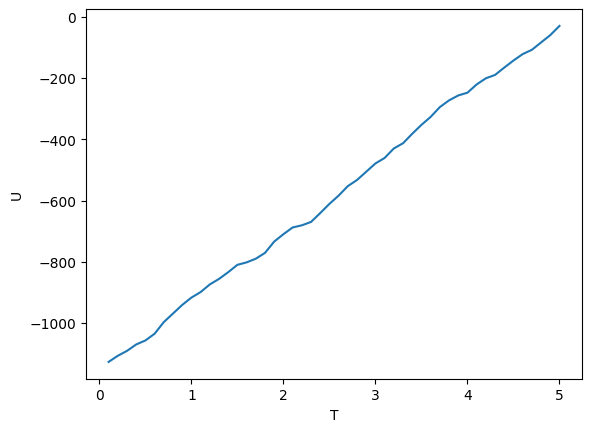

In [695]:
plt.figure()
plt.plot(T,E_mean)
plt.xlabel('T')
plt.ylabel('U')
plt.show()
#lattice_plots(lattice, np.arange(0,100,5))